# Doge Detector

with deep learning

![https://dogecoin.org/static/11cf6c18151cbb22c6a25d704ae7b313/dd8fa/doge-main.jpg](https://dogecoin.org/static/11cf6c18151cbb22c6a25d704ae7b313/dd8fa/doge-main.jpg)

In [1]:
import torch
import torchvision
import numpy as np
import json
import cv2
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create Dataset & DataLoader

In [2]:
DATSET_DIR = 'doge_image_alpha1_dataset'
BATCH_SIZE = 2

In [3]:
from torch.utils.data import Dataset
class Doge1Dataset(Dataset):
    def __init__(self, dataset_dir, test_split=False):
        self.dataset_dir_ = dataset_dir
        self.test_split_ = test_split
        
        # Read labels
        print('Read labels.json...')
        self.labels_ = json.load(open(os.path.join(self.dataset_dir_, 'labels.json')))
        filename2labels = {}
        for label in self.labels_:
            filename = label['External ID']
            filename2labels[filename] = label
        
        # Read list of image files
        self.items_ = []
        print('Read image files...')
        img_files = sorted(os.listdir(self.dataset_dir_))
        for i, img_file in enumerate(img_files):
            
            # split half half for train test
            is_test_example = i % 2 == 0
            if self.test_split_ and not is_test_example:
                continue
            if is_test_example and not self.test_split_:
                continue
            if 'labels' in img_file:
                continue
                
            # read image, save data
            img = cv2.imread(os.path.join(self.dataset_dir_, img_file))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            assert img.shape[0] > 100 and img.shape[1] > 100
            self.items_.append({
                'id': len(self.items_),
                'img_file': img_file,
                'raw_img': img,
                'label': filename2labels[img_file] if img_file in filename2labels else None
            })
        
        print('Done loading dataset!', len(self), 'items')
            
    def __len__(self):
        return len(self.items_)

    def __getitem__(self, idx):
        return {
            'id': idx,
            'image': self.items_[idx]['raw_img'],
            'bboxes':
              [o['bbox'] for o in self.items_[idx]['label']['Label']['objects']] \
                if self.items_[idx]['label'] is not None and 'objects' in self.items_[idx]['label']['Label'] else []
        }
            
    def viz_item(self, i):
        print('image file', self.items_[i]['img_file'])
        plt.imshow(self.items_[i]['raw_img'])

Read labels.json...
Read image files...
Done loading dataset! 158 items
image file 55.jpg


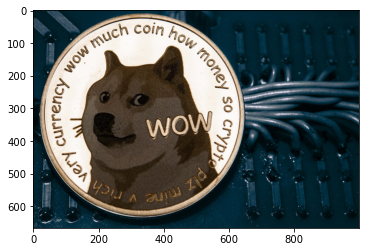

In [4]:
trainset = Doge1Dataset(DATSET_DIR, test_split=False)
trainset.viz_item(133)

In [5]:
trainset[133]

{'id': 133,
 'image': array([[[27, 66, 83],
         [25, 64, 81],
         [21, 60, 77],
         ...,
         [ 1, 25, 35],
         [ 1, 25, 35],
         [ 1, 25, 35]],
 
        [[ 7, 43, 59],
         [ 6, 42, 58],
         [ 3, 39, 55],
         ...,
         [ 1, 25, 35],
         [ 1, 25, 35],
         [ 1, 25, 35]],
 
        [[ 0, 29, 40],
         [ 0, 28, 39],
         [ 0, 27, 38],
         ...,
         [ 1, 25, 35],
         [ 1, 25, 35],
         [ 1, 25, 35]],
 
        ...,
 
        [[21, 58, 77],
         [21, 58, 77],
         [37, 75, 94],
         ...,
         [ 0, 29, 39],
         [ 0, 29, 39],
         [ 0, 29, 39]],
 
        [[34, 72, 91],
         [22, 60, 79],
         [24, 62, 81],
         ...,
         [ 0, 29, 39],
         [ 0, 29, 39],
         [ 0, 29, 39]],
 
        [[26, 64, 83],
         [ 7, 45, 64],
         [ 6, 44, 63],
         ...,
         [ 0, 29, 39],
         [ 0, 29, 39],
         [ 0, 29, 39]]], dtype=uint8),
 'bboxes': [{'top': 1

Read labels.json...
Read image files...
Done loading dataset! 158 items
image file 54.jpg


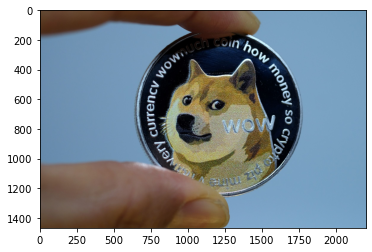

In [6]:
testset = Doge1Dataset(DATSET_DIR, test_split=True)
testset.viz_item(133)

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda batch: batch)
test_dataloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda batch: batch)

In [8]:
for batch in train_dataloader:
    print(len(batch))
    print('----')
    print(batch[0])
    break

2
----
{'id': 134, 'image': array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 25

# Create RetinaNet Model

In [9]:
DEVICE = 'cpu'
DEVICE = 'cuda'

print(torchvision.__version__)

0.8.2


In [10]:
model = torchvision.models.detection.retinanet_resnet50_fpn(pretrained=True)
model = model.to(DEVICE)

In [11]:
img = np.zeros([3, 224, 224])
img = torch.from_numpy(img).float()
img1 = img.to(DEVICE)
img2 = img.to(DEVICE)
model.train(False)
detections = model([img1, img2])
print(detections)

[{'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>), 'scores': tensor([], device='cuda:0', grad_fn=<CatBackward>), 'labels': tensor([], device='cuda:0', dtype=torch.int64)}, {'boxes': tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward>), 'scores': tensor([], device='cuda:0', grad_fn=<CatBackward>), 'labels': tensor([], device='cuda:0', dtype=torch.int64)}]


In [12]:
img = testset[3]['image'].transpose([2, 0, 1]) / 255.0
img = torch.from_numpy(img).float()
img = img.to(DEVICE)
model.train(False)
detections = model([img])
print(detections)

[{'boxes': tensor([[3.1435e+02, 1.8170e+02, 8.3190e+02, 9.2084e+02],
        [9.3736e+02, 1.6311e+02, 1.4706e+03, 9.3953e+02],
        [3.1791e+02, 1.9697e+02, 1.5704e+03, 1.0052e+03],
        [2.2938e+02, 1.2730e+02, 1.0109e+03, 9.9392e+02],
        [5.7329e+02, 7.7579e+01, 1.4947e+03, 9.8207e+02],
        [1.1206e+02, 5.2093e+02, 1.5626e+03, 1.0313e+03],
        [2.2938e+02, 1.2730e+02, 1.0109e+03, 9.9392e+02],
        [9.1079e+02, 1.5856e+02, 1.4504e+03, 9.2949e+02],
        [5.8440e+02, 8.8358e+02, 1.5807e+03, 1.0403e+03],
        [9.3619e+02, 1.7700e+02, 1.4676e+03, 9.3924e+02],
        [3.1162e+02, 1.7642e+02, 8.3857e+02, 9.1904e+02],
        [9.8217e+02, 7.9954e+02, 1.5049e+03, 9.4585e+02],
        [9.5828e+02, 7.0196e+02, 1.4855e+03, 9.2680e+02],
        [6.1204e+02, 4.5846e+02, 1.5398e+03, 9.6767e+02],
        [1.1777e+03, 8.0887e+01, 1.5723e+03, 9.2834e+02],
        [3.1240e+02, 1.7515e+02, 8.2907e+02, 9.0765e+02],
        [9.1189e+02, 1.7330e+02, 1.4547e+03, 9.3476e+02],
   

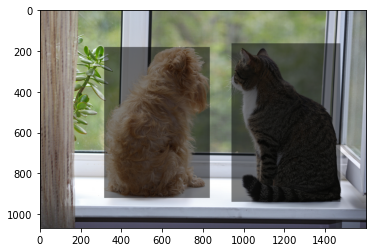

In [13]:
img = testset[3]['image'] + 0
for box in detections[0]['boxes'][0:2]:
    x1, y1, x2, y2 = box.detach().cpu().numpy().astype(np.int)
    img[y1:y2, x1:x2, :] = img[y1:y2, x1:x2, :] * 0.5
        
plt.imshow(img)



In [14]:
img = np.zeros([3, 224, 224])
img = torch.from_numpy(img).float()
img = img.to(DEVICE)

model.train(True)

targets = [{
  'boxes': torch.from_numpy(np.asarray([[1, 1, 10, 10]])).int().to(DEVICE),
  'labels': torch.from_numpy(np.asarray([1,])).long().to(DEVICE),
}]

losses = model([img], targets=targets)

print(losses)

{'classification': tensor(2.2268, device='cuda:0', grad_fn=<DivBackward0>), 'bbox_regression': tensor(1.5351, device='cuda:0', grad_fn=<DivBackward0>)}


/home/nam/anaconda3/envs/torch1/lib/python3.8/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Training duh

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

In [16]:
tracker = {'loss': []}
step = 0
for epoch in tqdm(range(50)):
    for batch in train_dataloader:
        step += 1
        
        # read the images from batch
        rawimgs = [item['image'] / 255.0 for item in batch]
        imgs = [img.transpose((2, 0, 1)) for img in rawimgs]
        imgs = [torch.from_numpy(img).float().to(DEVICE) for img in imgs]
        
        # read the labels from batch
        targets = []
        for item in batch:
            boxes = item['bboxes']
            l = [69 for box in boxes]
            l = torch.from_numpy(np.asarray(l)).long().to(DEVICE)
            b = [[b['left'], b['top'], b['left'] + b['width'], b['top'] + b['height']] for b in boxes]
            b = torch.from_numpy(np.asarray(b + [[0, 0, 0, 0]]))[:-1, :].long().to(DEVICE)
            targets.append({
                'boxes': b,
                'labels': l
            })
        
        # run model & get loss value
        model.train()
        losses = model(imgs, targets)
        total_loss = sum([v for k, v in losses.items()])
        
        # gradient decent step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        tracker['loss'].append(float(total_loss))
        del imgs, losses, total_loss, targets
        
    print('step', step, 'loss', np.mean(tracker['loss'][-100:]))

  2%|▏         | 1/50 [00:42<35:06, 43.00s/it]

step 79 loss 2.038406272854986


  4%|▍         | 2/50 [01:26<34:29, 43.12s/it]

step 158 loss 0.7957495800405741


  6%|▌         | 3/50 [02:13<34:40, 44.27s/it]

step 237 loss 0.6051826880779118


  8%|▊         | 4/50 [03:11<37:08, 48.45s/it]

step 316 loss 0.5235357651859522


 10%|█         | 5/50 [03:54<35:10, 46.91s/it]

step 395 loss 0.4428369981073774


 12%|█▏        | 6/50 [04:36<33:14, 45.33s/it]

step 474 loss 0.3995198777248152


 14%|█▍        | 7/50 [05:19<32:02, 44.71s/it]

step 553 loss 0.3639840799733065


 16%|█▌        | 8/50 [06:02<30:52, 44.11s/it]

step 632 loss 0.33531979984400095


 18%|█▊        | 9/50 [06:56<32:13, 47.16s/it]

step 711 loss 0.3170871913642623


 20%|██        | 10/50 [07:43<31:26, 47.17s/it]

step 790 loss 0.279204343954334


 22%|██▏       | 11/50 [08:27<29:54, 46.01s/it]

step 869 loss 0.27949583017631086


 24%|██▍       | 12/50 [09:09<28:25, 44.87s/it]

step 948 loss 0.2967780988222512


 26%|██▌       | 13/50 [09:52<27:24, 44.44s/it]

step 1027 loss 0.21733656641910784


 28%|██▊       | 14/50 [10:35<26:20, 43.90s/it]

step 1106 loss 0.19969539478828666


 30%|███       | 15/50 [11:17<25:20, 43.45s/it]

step 1185 loss 0.17782342764374334


 32%|███▏      | 16/50 [12:00<24:25, 43.11s/it]

step 1264 loss 0.17898202939220936


 34%|███▍      | 17/50 [12:43<23:42, 43.10s/it]

step 1343 loss 0.167767607185815


 36%|███▌      | 18/50 [13:25<22:45, 42.67s/it]

step 1422 loss 0.152329906077357


 38%|███▊      | 19/50 [14:07<21:56, 42.48s/it]

step 1501 loss 0.1473794078202627


 40%|████      | 20/50 [14:50<21:19, 42.63s/it]

step 1580 loss 0.13815592478320468


 42%|████▏     | 21/50 [15:29<20:10, 41.73s/it]

step 1659 loss 0.1470655195924337


 44%|████▍     | 22/50 [16:09<19:10, 41.07s/it]

step 1738 loss 0.13682178933784597


 46%|████▌     | 23/50 [16:48<18:17, 40.63s/it]

step 1817 loss 0.12276897646879661


 48%|████▊     | 24/50 [17:30<17:45, 40.97s/it]

step 1896 loss 0.11742601939797169


 50%|█████     | 25/50 [18:12<17:13, 41.36s/it]

step 1975 loss 0.10651706716846093


 52%|█████▏    | 26/50 [18:56<16:50, 42.11s/it]

step 2054 loss 0.09928621693179593


 54%|█████▍    | 27/50 [19:38<16:09, 42.15s/it]

step 2133 loss 0.10020766275978531


 56%|█████▌    | 28/50 [20:22<15:39, 42.70s/it]

step 2212 loss 0.10596480838386924


 58%|█████▊    | 29/50 [21:04<14:51, 42.47s/it]

step 2291 loss 0.08999433302131365


 60%|██████    | 30/50 [21:47<14:08, 42.41s/it]

step 2370 loss 0.09220829359561321


 62%|██████▏   | 31/50 [22:31<13:36, 42.98s/it]

step 2449 loss 0.08227546667374554


 64%|██████▍   | 32/50 [23:14<12:52, 42.91s/it]

step 2528 loss 0.08668294861796312


 66%|██████▌   | 33/50 [23:56<12:05, 42.66s/it]

step 2607 loss 0.08325887577128015


 68%|██████▊   | 34/50 [24:38<11:21, 42.61s/it]

step 2686 loss 0.0767904993976117


 70%|███████   | 35/50 [25:20<10:35, 42.37s/it]

step 2765 loss 0.07637981842846785


 72%|███████▏  | 36/50 [26:02<09:51, 42.27s/it]

step 2844 loss 0.0717550201198901


 74%|███████▍  | 37/50 [26:45<09:13, 42.55s/it]

step 2923 loss 0.07040082919804264


 76%|███████▌  | 38/50 [27:26<08:25, 42.14s/it]

step 3002 loss 0.06716655739437556


 78%|███████▊  | 39/50 [28:10<07:46, 42.42s/it]

step 3081 loss 0.12829110842812952


 80%|████████  | 40/50 [28:51<07:01, 42.15s/it]

step 3160 loss 0.08212113896239316


 82%|████████▏ | 41/50 [29:33<06:19, 42.13s/it]

step 3239 loss 0.06820260557055008


 84%|████████▍ | 42/50 [30:13<05:32, 41.54s/it]

step 3318 loss 0.0691815953834157


 86%|████████▌ | 43/50 [30:55<04:50, 41.47s/it]

step 3397 loss 0.06354091973465983


 88%|████████▊ | 44/50 [31:38<04:11, 41.90s/it]

step 3476 loss 0.05946985287722782


 90%|█████████ | 45/50 [32:21<03:32, 42.46s/it]

step 3555 loss 0.06908748414862202


 92%|█████████▏| 46/50 [33:04<02:50, 42.61s/it]

step 3634 loss 0.060073411072662564


 94%|█████████▍| 47/50 [33:50<02:10, 43.66s/it]

step 3713 loss 0.05064148813602515


 96%|█████████▌| 48/50 [34:38<01:29, 44.78s/it]

step 3792 loss 0.06436332862576818


 98%|█████████▊| 49/50 [35:21<00:44, 44.32s/it]

step 3871 loss 0.06365687044119113


100%|██████████| 50/50 [36:05<00:00, 43.31s/it]

step 3950 loss 0.050038838281980136


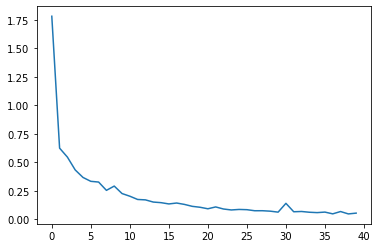

In [17]:
plt.plot([
    np.mean(tracker['loss'][i:(i+100)]) 
    for i in range(0, len(tracker['loss']), 100)
])

0.05331411212682724


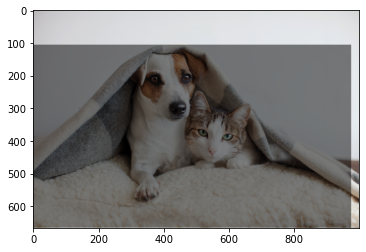

0.9125184416770935


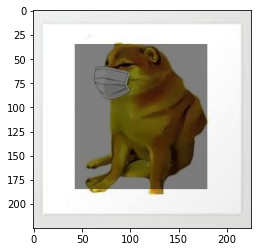

0.05764731019735336


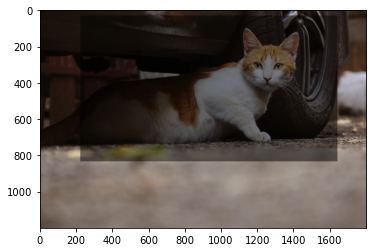

0.8675128221511841


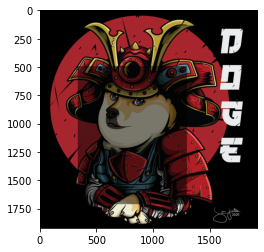

0.09939289093017578


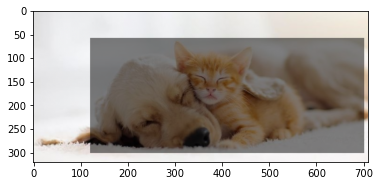

0.9891401529312134


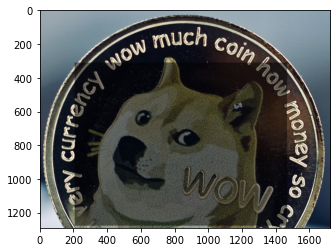

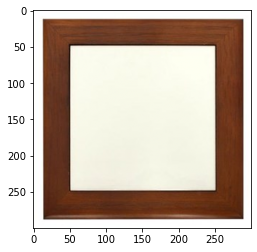

0.41577836871147156


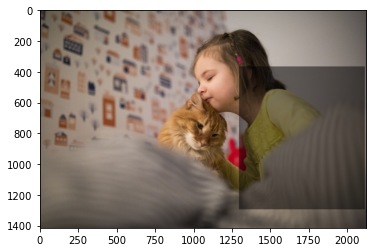

0.08401426672935486


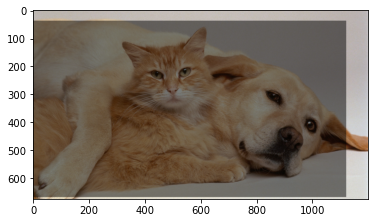

0.055630750954151154


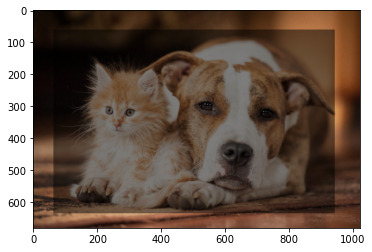

0.06133970618247986


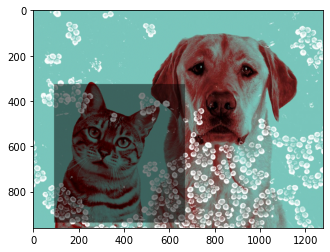

0.9704922437667847


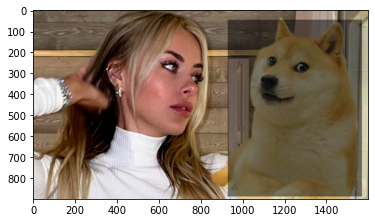

0.9088391661643982


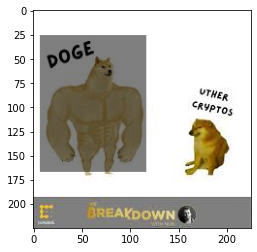

0.47199442982673645


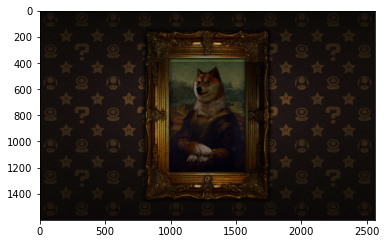

0.06550464034080505


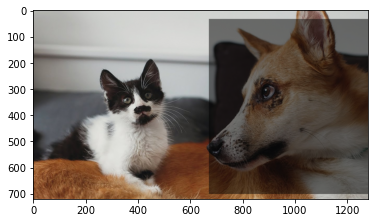

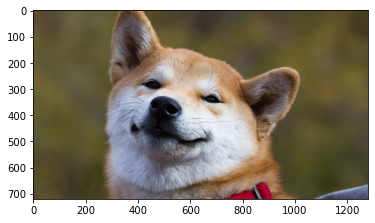

0.12653037905693054


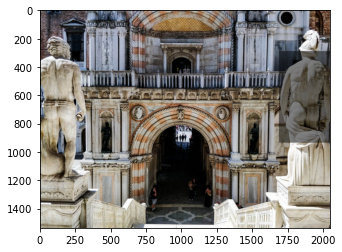

0.4401903450489044


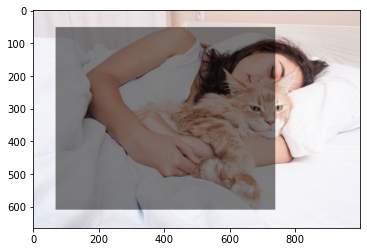

0.30795419216156006


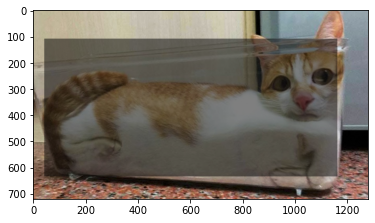

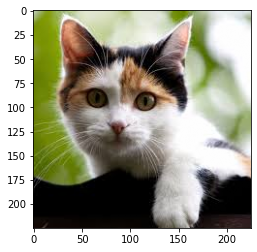

In [23]:
for batch in test_dataloader:
    # run model on test images
    rawimgs = [item['image'] / 255.0 for item in batch]
    imgs = [img.transpose((2, 0, 1)) for img in rawimgs]
    imgs = [torch.from_numpy(img).float().to(DEVICE) for img in imgs]
    model.eval()
    detections = model(imgs)

    # viz result
    for img, detection in zip(rawimgs, detections):
        for box, score, label in zip(detection['boxes'], detection['scores'], detection['labels']):
            if score > 0.05 and int(label) == 69:
                x1, y1, x2, y2 = box
                x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
                img[y1:y2, x1:x2, :] /= 2
                print(float(score))
                break

        plt.imshow(img)
        plt.show()


In [19]:
torch.save(model.state_dict(), 'model.pth')

In [20]:
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>